In [1]:
from settings import *

##### Set global constants for this experiment

In [2]:
delta_t = 0.1
N = 1
L = 100
distance = 0.9
depth = 10


##### Load observables

In [3]:
Os = all_observables(m=m)
jump_oper_decay = default_jump_operators(m=m, gammas=gammas)
jump_oper_no_decay = no_decay_jump_operators()

##### Make training data

In [4]:
rho0s = random_rho0s(m=m, L=L, seed=34421)
rhoss, ts = solve_lindblad_rho0s(rho0s=rho0s, delta_t=delta_t, N=N, s=system, jump_opers=jump_oper_decay)
training_data = mk_training_data(rhoss=rhoss, Os=Os)

##### Create a qubit layout and a parametrized circuit on those qubits

In [5]:
qubits = TriangularLayoutA(m=m, distance=distance)
circuit = HEA_fac(qubits, depth=depth)

<Axes: title={'center': 'Qubit layout'}>

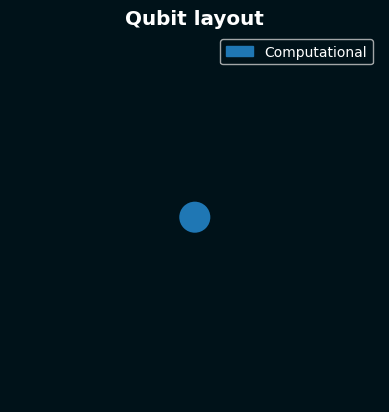

In [6]:
qubits.show_layout()

In [7]:
# optionally load already optimized theta

# theta_opt = np.load("ham_theta_opt.npy")

##### Optimize the parameters

In [8]:
theta_opt, errors, thetas = optimize(
    circuit=circuit,
    training_data=training_data,
    n_grad=10,
    max_count=100,
    seed=59308
)

# optionally, save the results of the optimization process

theta_opt = np.save("ham_theta_opt.npy", theta_opt)
thetas = np.save("ham_thetas.npy", thetas)
errors = np.save("ham_errors.npy", errors)

C:\Users\Admin\Desktop\BFP\quantum-channel-approximation\q_channel_approx\optimizer.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
  errors[i] = error


small sigma
Zero gradient hit after 34 iterations


In [9]:
theta_opt = np.load("ham_theta_opt.npy")
thetas = np.load("ham_thetas.npy")
errors = np.load("ham_errors.npy")

Text(0, 0.5, 'error')

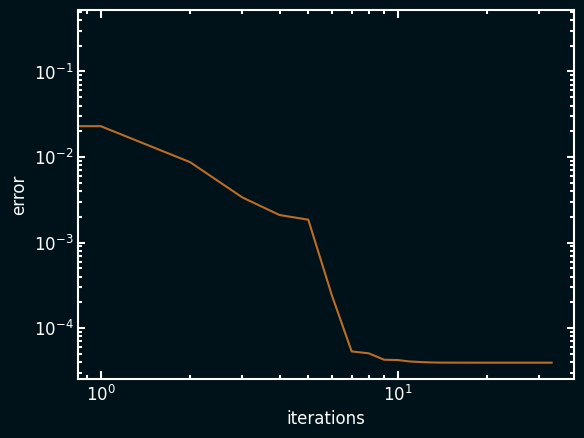

In [10]:
plt.loglog(errors)
plt.xlabel("iterations")
plt.ylabel("error")

##### Compare approximated Hamiltonian to the actual Hamiltonian

In [11]:
eH_approx = -circuit(theta_opt) # with the minus the result is much closer, but why?
H_approx = sc.linalg.logm(eH_approx) / (-1j * delta_t)

H_ref = create_hamiltonian(system).full()
eH_ref = sc.linalg.expm((-1j) * delta_t * H_ref)

In [12]:
eH_approx

array([[ 9.99997794e-01-9.26936453e-05j, -3.97979642e-05-2.09825648e-03j],
       [ 3.97979642e-05-2.09825648e-03j,  9.99997794e-01+9.26936453e-05j]])

In [13]:
eH_ref

array([[0.99500417-0.09983342j, 0.        +0.j        ],
       [0.        +0.j        , 0.99500417-0.09983342j]])

In [14]:
H_ref

array([[1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j]])

In [15]:
H_approx

array([[ 0.00092694+4.69459541e-16j,  0.02098258-3.97979935e-04j],
       [ 0.02098258+3.97979935e-04j, -0.00092694-1.09992310e-15j]])

##### Plot approximated solution compared to reference solution

In [20]:
n_time_steps = 100

rho0 = rho_rand_haar(m=m)

Os_comp = [O.full() for O in create_observables_comp_basis(m=m)]

rho_rand_haar: seed=12665


In [21]:
# calculate reference solution

rhos_ref, ts = solve_lindblad_rho0(
    rho0,
    delta_t=delta_t,
    N=n_time_steps,
    s=system,
    jump_opers=jump_oper_decay,
)
Ess_ref = measure_rhos([r.full() for r in rhos_ref], Os_comp)

rhos_ref_no_decay, ts = solve_lindblad_rho0(
    rho0,
    delta_t=delta_t,
    N=n_time_steps,
    s=system,
    jump_opers=jump_oper_no_decay,
)
Ess_ref_no_decay = measure_rhos([r.full() for r in rhos_ref_no_decay], Os_comp)

# calculate approximated solution

evolver = evolver_fac(circuit, theta_opt)
rhos_approx = evolver(n=n_time_steps, rho=rho0.full())
Ess_approx = measure_rhos(rhos_approx, Os_comp)

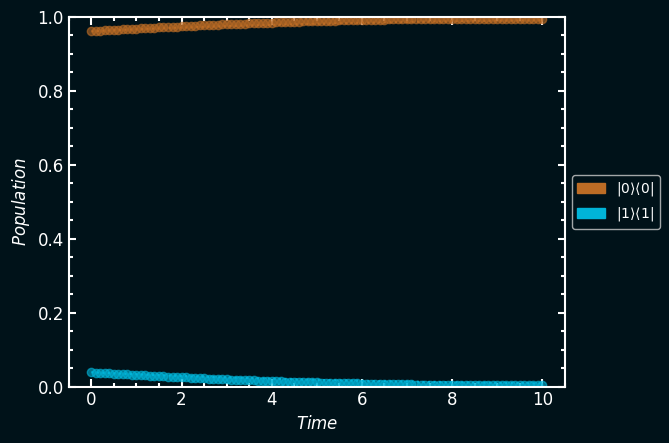

In [22]:
plot_ref(ts, Ess_ref)
plot_approx(ts, Ess_approx)

plt.ylabel("$Population$")
plt.xlabel("$Time$")
plt.ylim(0, 1)
plt.gca().legend(handles=legend_comp(m), loc="center left", bbox_to_anchor=(1, 0.5))

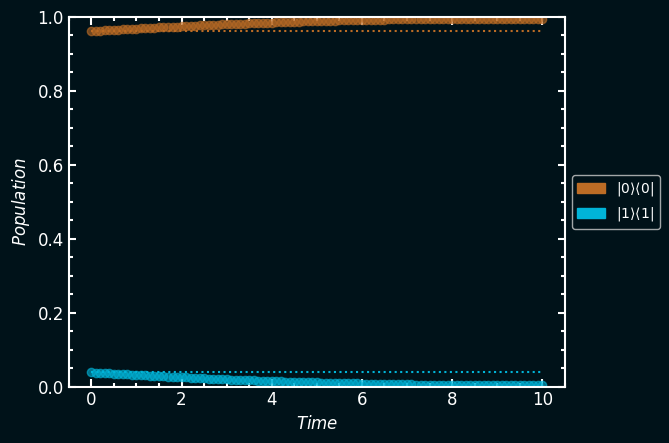

In [23]:
plot_approx(ts, Ess_approx)
plot_ref(ts, Ess_ref_no_decay)


# some formatting to make plot look nice
plt.ylabel("$Population$")
plt.xlabel("$Time$")
plt.ylim(0, 1)
plt.gca().legend(handles=legend_comp(m), loc="center left", bbox_to_anchor=(1, 0.5))